## RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением.<br> 
Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии.<br> 
Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

### Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.<br><br>
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
*	численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
*	туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть **usable ace**), и за 1 очко, если превосходит;
*	игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
*	игрок может совершать одно из двух действий:
    1.	**hit**  — взять ещё одну карту;
    2.	**stand** — не брать больше карт;
*	если сумма очков у игрока на руках больше 21, он проигрывает (**bust**);
*	если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
*	после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
*	в исходных правилах есть ещё дополнительный бонус за **natural blackjack**: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в [OpenAI Gym](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py).<br>
1.	Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2.	Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
3.	Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
import gym
from tqdm import tqdm
from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

import warnings
warnings.filterwarnings('ignore')

N = 100000 # количество эпизодов для получения матрицы Q(s,a)
K = 500 # количество предыдущих эпизодов, по которому усредняем доход за эпизод для графиков
M = 100000 # количество эпизодов, которое проигрываем для оценки полученной матрицы Q(s,a) 

In [2]:
# natural=True - дополнительный бонус за natural blackjack
def get_env(env_type='simple'):
    if env_type == 'simple':
        return gym.make('Blackjack-v1', natural=True)
    elif env_type == 'double':
        return BlackjackDoubleEnv(natural=True)
    elif env_type == 'count':
        return BlackjackDoubleCountEnv(natural=True)
    else:
        print('Bad environment type.')
        return None

#### 1. Простая стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

In [3]:
def simple_strategy(episodes=1000, debug=False):
    total_rewards = []
    mean_rewards = []
    for episod in tqdm(range(episodes)):
        if debug: print('\nSTART_episode')
        env = get_env(env_type='simple')  # инициализируем окружение
        observation = env.reset()  # первая раздача
        total_score = observation[0][0]  # стартовое количество очков
        done = False
        while not done:
            if debug: print(f'total_score={total_score}')
            if total_score in [19, 20, 21]:
                action = 0  # stand
                if debug: print(f'    action: stand')
            else:
                action = 1  # hit
                if debug: print(f'    action: hit')
            observation, reward, done, info, _ = env.step(action)
            total_score, _, _ = observation
        total_rewards.append(reward)  # массив наград за все эпизоды
        mean_rewards.append(np.mean(total_rewards[-K:]))  # средний доход за эпизод (усредняем по K последним раздачам)
        if debug: print(f'episode_reward={reward}')
        if debug: print('END_episode\n')
        env.close()
    return total_rewards, mean_rewards

In [4]:
# Check game
check = simple_strategy(episodes=3, debug=True)

100%|██████████| 3/3 [00:00<00:00, 87.02it/s]


START_episode
total_score=11
    action: hit
total_score=21
    action: stand
episode_reward=0.0
END_episode


START_episode
total_score=20
    action: stand
episode_reward=0.0
END_episode


START_episode
total_score=16
    action: hit
episode_reward=-1.0
END_episode



In [5]:
# Check Simple Strategy for M episodes
total_reward_simple, mean_reward_simple = simple_strategy(episodes=M)
print(f'Количество эпизодов: {M}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_simple)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_simple[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_simple[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_simple)}')

100%|██████████| 100000/100000 [00:52<00:00, 1910.44it/s]

Количество эпизодов: 100000
Средний выигрыш за эпизод: -0.1982
Средний выигрыш за эпизод за первые 500 эпизодов: -0.224
Средний выигрыш за эпизод за последние 500 эпизодов: -0.104
Общий выигрыш по всем эпизодам: -19820.0


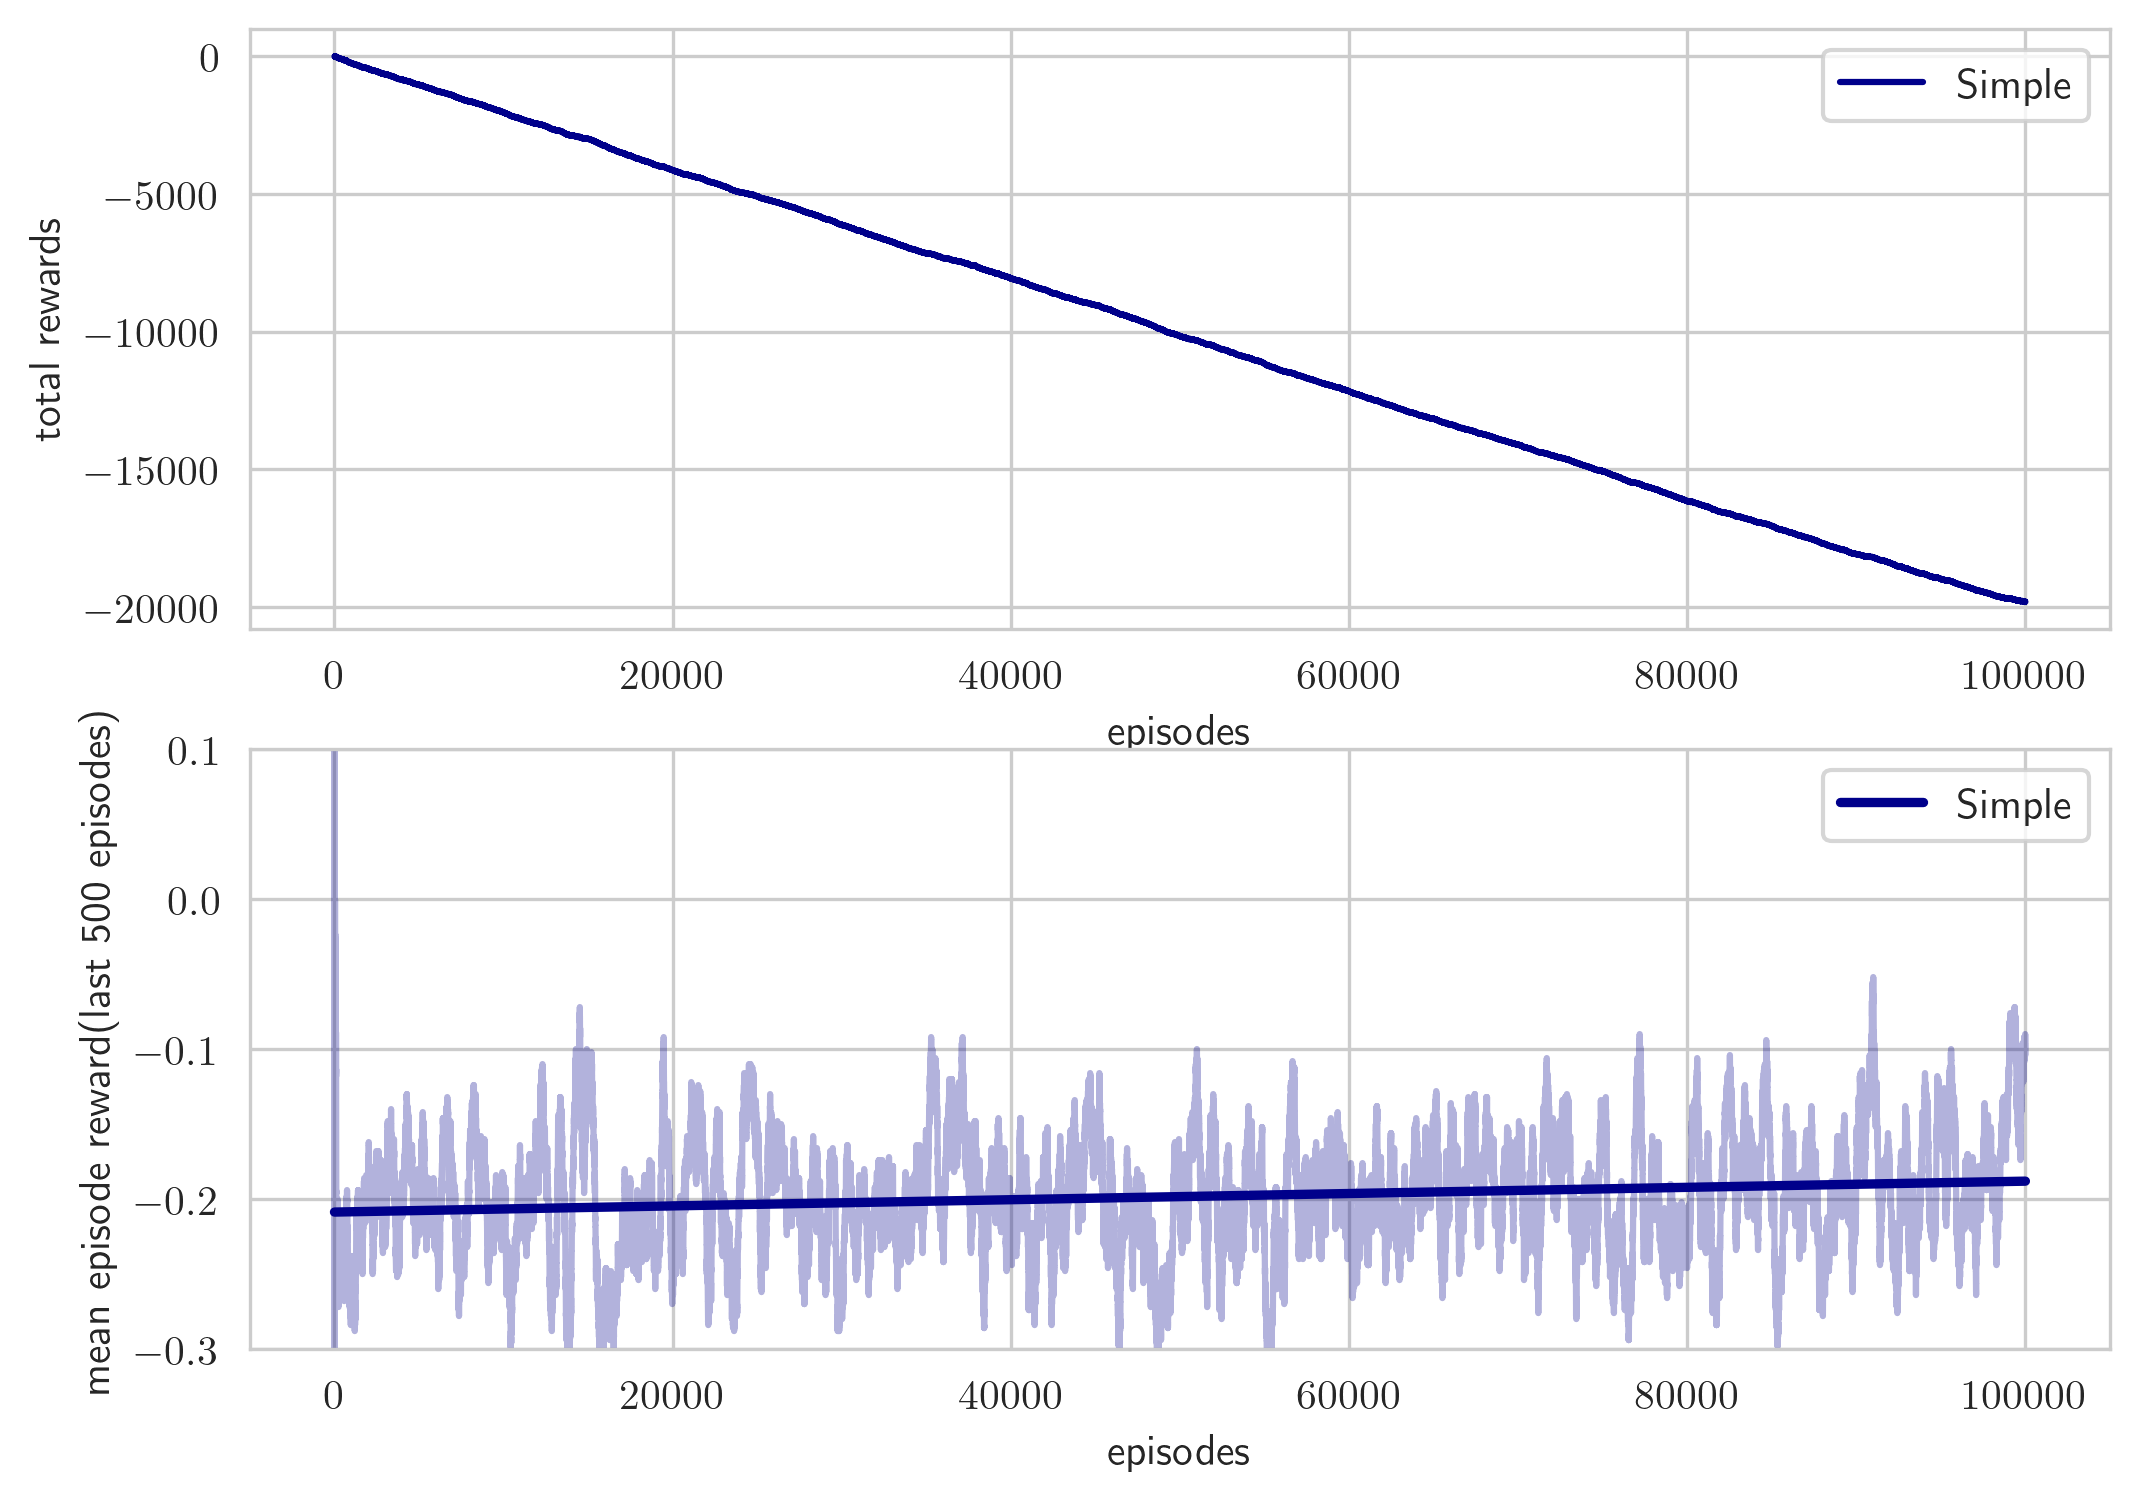

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

axes[0].plot(np.cumsum(total_reward_simple), color='DarkBlue', label='Simple')
axes[0].set_xlabel('episodes')
axes[0].set_ylabel('total rewards')
axes[0].legend()

axes[1].plot(mean_reward_simple, color='DarkBlue', alpha=0.3)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_simple,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkBlue',
    label='Simple',
)
axes[1].set_xlabel('episodes')
axes[1].set_ylabel(f'mean episode reward(last {K} episodes)')
axes[1].set_ylim([-0.3,0.1])
axes[1].legend()

fig.subplots_adjust(bottom=0.000)
plt.show()

#### Вывод: с простой стратегией мы теряем примерно 0.198 за эпизод.

#### 2. Метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [7]:
# Проигрываем большое количество эпизодов и собираем информацию о возможных состояниях - нужно для построения матрицы Q(s,a)
def get_states(get_env, env_type, actions=2, episodes=1000):
    states = []
    for i in tqdm(range(episodes)):
        env = get_env(env_type)  # инициализируем окружение
        observation = env.reset()  # первая раздача
        states.append(observation[0])
        done = False
        while not done:
            action = np.random.randint(0, actions)
            observation, reward, done, info, _ = env.step(action)
            states.append(observation)
        env.close()
    return list(set(states))  # Сразу уберем дублированные состояния

In [8]:
A = [0, 1]  # Пространство возможных действий
S = get_states(get_env, env_type='simple', episodes=10000)  # Пространство исследованных возможных состояний
print(f'|S|={len(S)}')

# Словари для обращения к матрице Q(s,a)
action_to_id = {a: i for i, a in enumerate(A)}
id_to_action = {i: a for i, a in enumerate(A)}
state_to_id = {s: i for i, s in enumerate(S)}
id_to_state = {i: s for i, s in enumerate(S)}

100%|██████████| 10000/10000 [00:04<00:00, 2033.51it/s]

|S|=380


Используем $\epsilon$ -жадную q-learning стратегию:<br>
Инициализируем матрицу Q(s,a) нулями. <br>
Будем проигрывать эпизоды и обновлять матрицу по формуле:$Q[s,a]=(1-\alpha)Q[s,a]+\alpha(r+\gamma arg max(Q[s']))$.<br>
В качестве действия выбираем argmax с вероятностью $1-\epsilon$ и случайное действие с вероятностью $\epsilon$.

In [9]:
def eps_greedy_Q_learning_strategy(alpha=0.05, epsilon=0.1, gamma=0.9, episodes=1000, debug=False):
    Q = np.zeros((len(S), len(A)))  # Инициализируем матрицу Q нулями
    total_rewards = []  # массив наград за все эпизоды
    mean_rewards = []  # средний доход за эпизод (усредняем по K последним раздачам) 
    for i in tqdm(range(episodes)):
        if debug: print('\nSTART_episode')
        env = get_env(env_type='simple')  # инициализируем окружение
        observation = env.reset()  # первая раздача
        total_score = observation[0][0]  # стартовое количество очков
        state_id = state_to_id[observation[0]]
        done = False
        while not done:
            if debug: print(f'total_score={total_score}')
            # argmax с вероятностью 1-eps и случайное действие с вероятностью eps
            if np.random.rand() > epsilon:
                action_id = np.argmax(Q[state_id])
            else:
                action_id = np.random.choice(list(action_to_id.keys()))
            if debug: print(f'    action: {action_id}')
            observation, reward, done, info, _ = env.step(id_to_action[action_id])
            total_score, _, _ = observation
            state_id_new = state_to_id[observation]
            Q[state_id, action_id] = (1 - alpha) * Q[state_id, action_id] + alpha * (reward + gamma * np.max(Q[state_id_new]))
            state_id = state_id_new
        total_rewards.append(reward)
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f'episode_reward={reward}')
        if debug: print('END_episode\n')
        env.close()
    return total_rewards, mean_rewards, Q


In [10]:
# Check game
check = eps_greedy_Q_learning_strategy(epsilon=0.5, episodes=3, debug=True)

100%|██████████| 3/3 [00:00<00:00, 310.31it/s]


START_episode
total_score=9
    action: 1
total_score=17
    action: 0
episode_reward=-1.0
END_episode


START_episode
total_score=20
    action: 0
episode_reward=-1.0
END_episode


START_episode
total_score=20
    action: 0
episode_reward=1.0
END_episode



In [11]:
# Возьмем пока alpha=0.05, epsilon=0.1, gamma=0.9
total_reward_q, mean_reward_q, Q = eps_greedy_Q_learning_strategy(episodes=N)
print(f'Количество эпизодов: {N}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q)}')

100%|██████████| 100000/100000 [01:11<00:00, 1401.87it/s]

Количество эпизодов: 100000
Средний выигрыш за эпизод: -0.18703
Средний выигрыш за эпизод за первые 500 эпизодов: -0.21
Средний выигрыш за эпизод за последние 500 эпизодов: -0.116
Общий выигрыш по всем эпизодам: -18703.0


#### Вывод: получилось, что с  Q-learning стратегией мы теряем за эпизод немного меньше, чем с простой стратегией, примерно 0.187. Попробуем подобрать параметры $\epsilon$, $\alpha$ и $\gamma$, чтобы улучшить результат. Для подбора параметров возпользуемся optuna.

#### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Q-learning стратегия показала себя чуть лучше простой стратегии. По идее, по мере уточнения матрицы Q, Q-learning стратегия должна улучшать свой результат. Попробуем подобрать оптимальные параметры $\epsilon, \alpha$ и $\gamma$ и построить график среднего дохода по мере получения матрицы Q.<br><br>
**Будем смотреть на два графика:**
1. Общий суммарный доход по всем эпизодам
2. Доход за эпизод, усредненный по 500 предыдущим раздачам - хотим увидеть динамику обучения, как результат уточнения матрицы Q(s,a)

In [12]:
import optuna

In [13]:
def optimize_reward(trial):
    alpha = trial.suggest_float('alpha', 0, 1)
    epsilon = trial.suggest_float('epsilon', 0, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    # Максимизируем значение среднего дохода за эпизод
    return np.mean(eps_greedy_Q_learning_strategy(alpha=alpha, epsilon=epsilon, gamma=gamma, episodes=5000)[0])

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_reward, n_trials=200, show_progress_bar=False)
clear_output(wait=False)  # Чтобы не засорять экран

In [15]:
alpha = study.best_params['alpha']
epsilon = study.best_params['epsilon']
gamma = study.best_params['gamma']

print(f'BEST params: alpha={alpha}, epsilon={epsilon}, gamma={gamma}')
total_reward_q_opt, mean_reward_q_opt, Q_opt = eps_greedy_Q_learning_strategy(alpha=alpha, epsilon=epsilon, gamma=gamma, episodes=N)
print(f'Количество эпизодов: {N}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q_opt)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q_opt[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q_opt[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q_opt)}')

BEST params: alpha=0.029361743122112885, epsilon=0.00022710839740023138, gamma=0.12306464418542123


100%|██████████| 100000/100000 [01:00<00:00, 1662.13it/s]

Количество эпизодов: 100000
Средний выигрыш за эпизод: -0.05891
Средний выигрыш за эпизод за первые 500 эпизодов: -0.15
Средний выигрыш за эпизод за последние 500 эпизодов: -0.016
Общий выигрыш по всем эпизодам: -5891.0


Графики - результат, полученный **во время вычисления матрицы Q**: сверху - суммарный доход по всем эпизодам, снизу - доход за эпизод, усредненный по предыдущим 500 эпизодам.

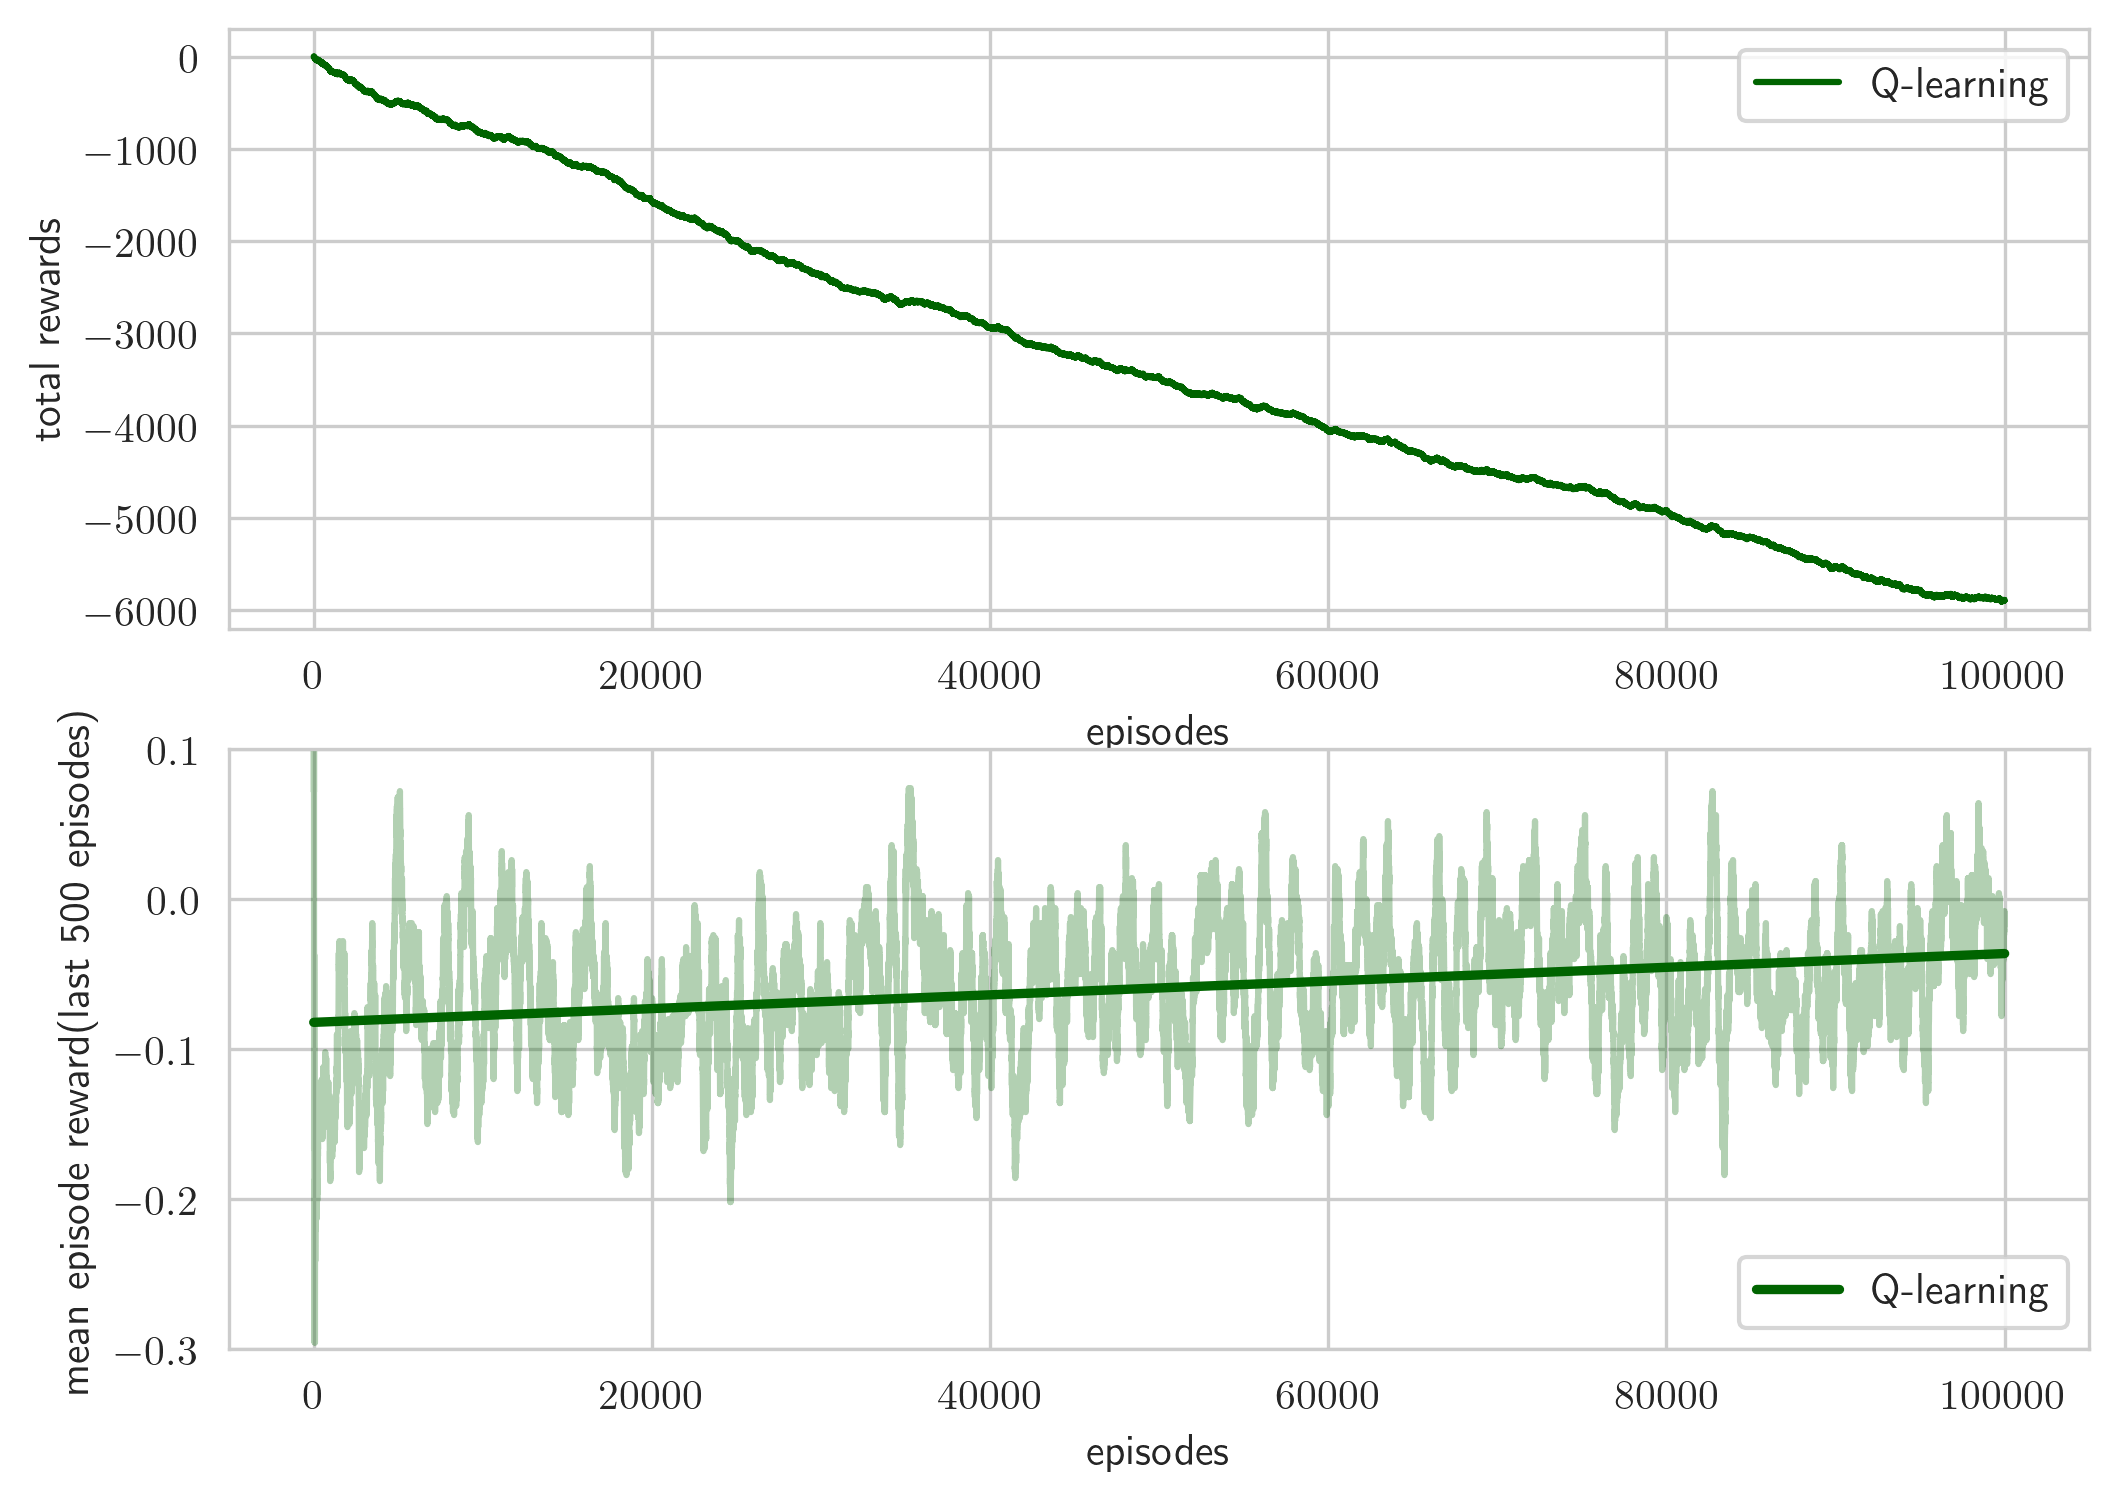

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

axes[0].plot(np.cumsum(total_reward_q_opt), color='DarkGreen', label='Q-learning')
axes[0].set_xlabel('episodes')
axes[0].set_ylabel('total rewards')
axes[0].legend()

axes[1].plot(mean_reward_q_opt, color='DarkGreen', alpha=0.3)


sns.regplot(
    x=list(range(N)),
    y=mean_reward_q_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkGreen',
    label='Q-learning'
)
axes[1].set_xlabel('episodes')
axes[1].set_ylabel(f'mean episode reward(last {K} episodes)')
axes[1].set_ylim([-0.3,0.1])
axes[1].legend()


fig.subplots_adjust(bottom=0.000)
plt.show()

Тренд на увеличение среднего дохода за эпизод на графике визуально прослеживается.

Теперь проиграем 100000 эпизодов, используя полученную матрицу Q_opt.

In [17]:
def play_blackjack_using_Q(Q, episodes=1000, env_type='simple'):
    total_rewards = []  # массив наград за все эпизоды
    mean_rewards = []  # средний доход за эпизод (усредняем по K последним раздачам) 
    for i in tqdm(range(episodes)):
        env = get_env(env_type=env_type)  # инициализируем окружение
        observation = env.reset()  # первая раздача
        state_id = state_to_id[observation[0]]
        done = False
        while not done:
            action_id = np.argmax(Q[state_id])
            observation, reward, done, info, _ = env.step(id_to_action[action_id])
            state_id_new = state_to_id[observation]
            state_id = state_id_new
        total_rewards.append(reward)
        mean_rewards.append(np.mean(total_rewards[-K:]))
        env.close()
    return total_rewards, mean_rewards

In [18]:
total_reward_q_opt, mean_reward_q_opt = play_blackjack_using_Q(Q_opt, episodes=M, env_type='simple')
print(f'Количество эпизодов: {M}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q_opt)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q_opt[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q_opt[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q_opt)}')

100%|██████████| 100000/100000 [00:56<00:00, 1754.52it/s]

Количество эпизодов: 100000
Средний выигрыш за эпизод: -0.05607
Средний выигрыш за эпизод за первые 500 эпизодов: -0.096
Средний выигрыш за эпизод за последние 500 эпизодов: -0.108
Общий выигрыш по всем эпизодам: -5607.0


Графики: сверху - суммарный доход по всем эпизодам, снизу - доход за эпизод, усредненный по предыдущим 500 эпизодам.<br>
Результат по простой стратегии - для сравнения.

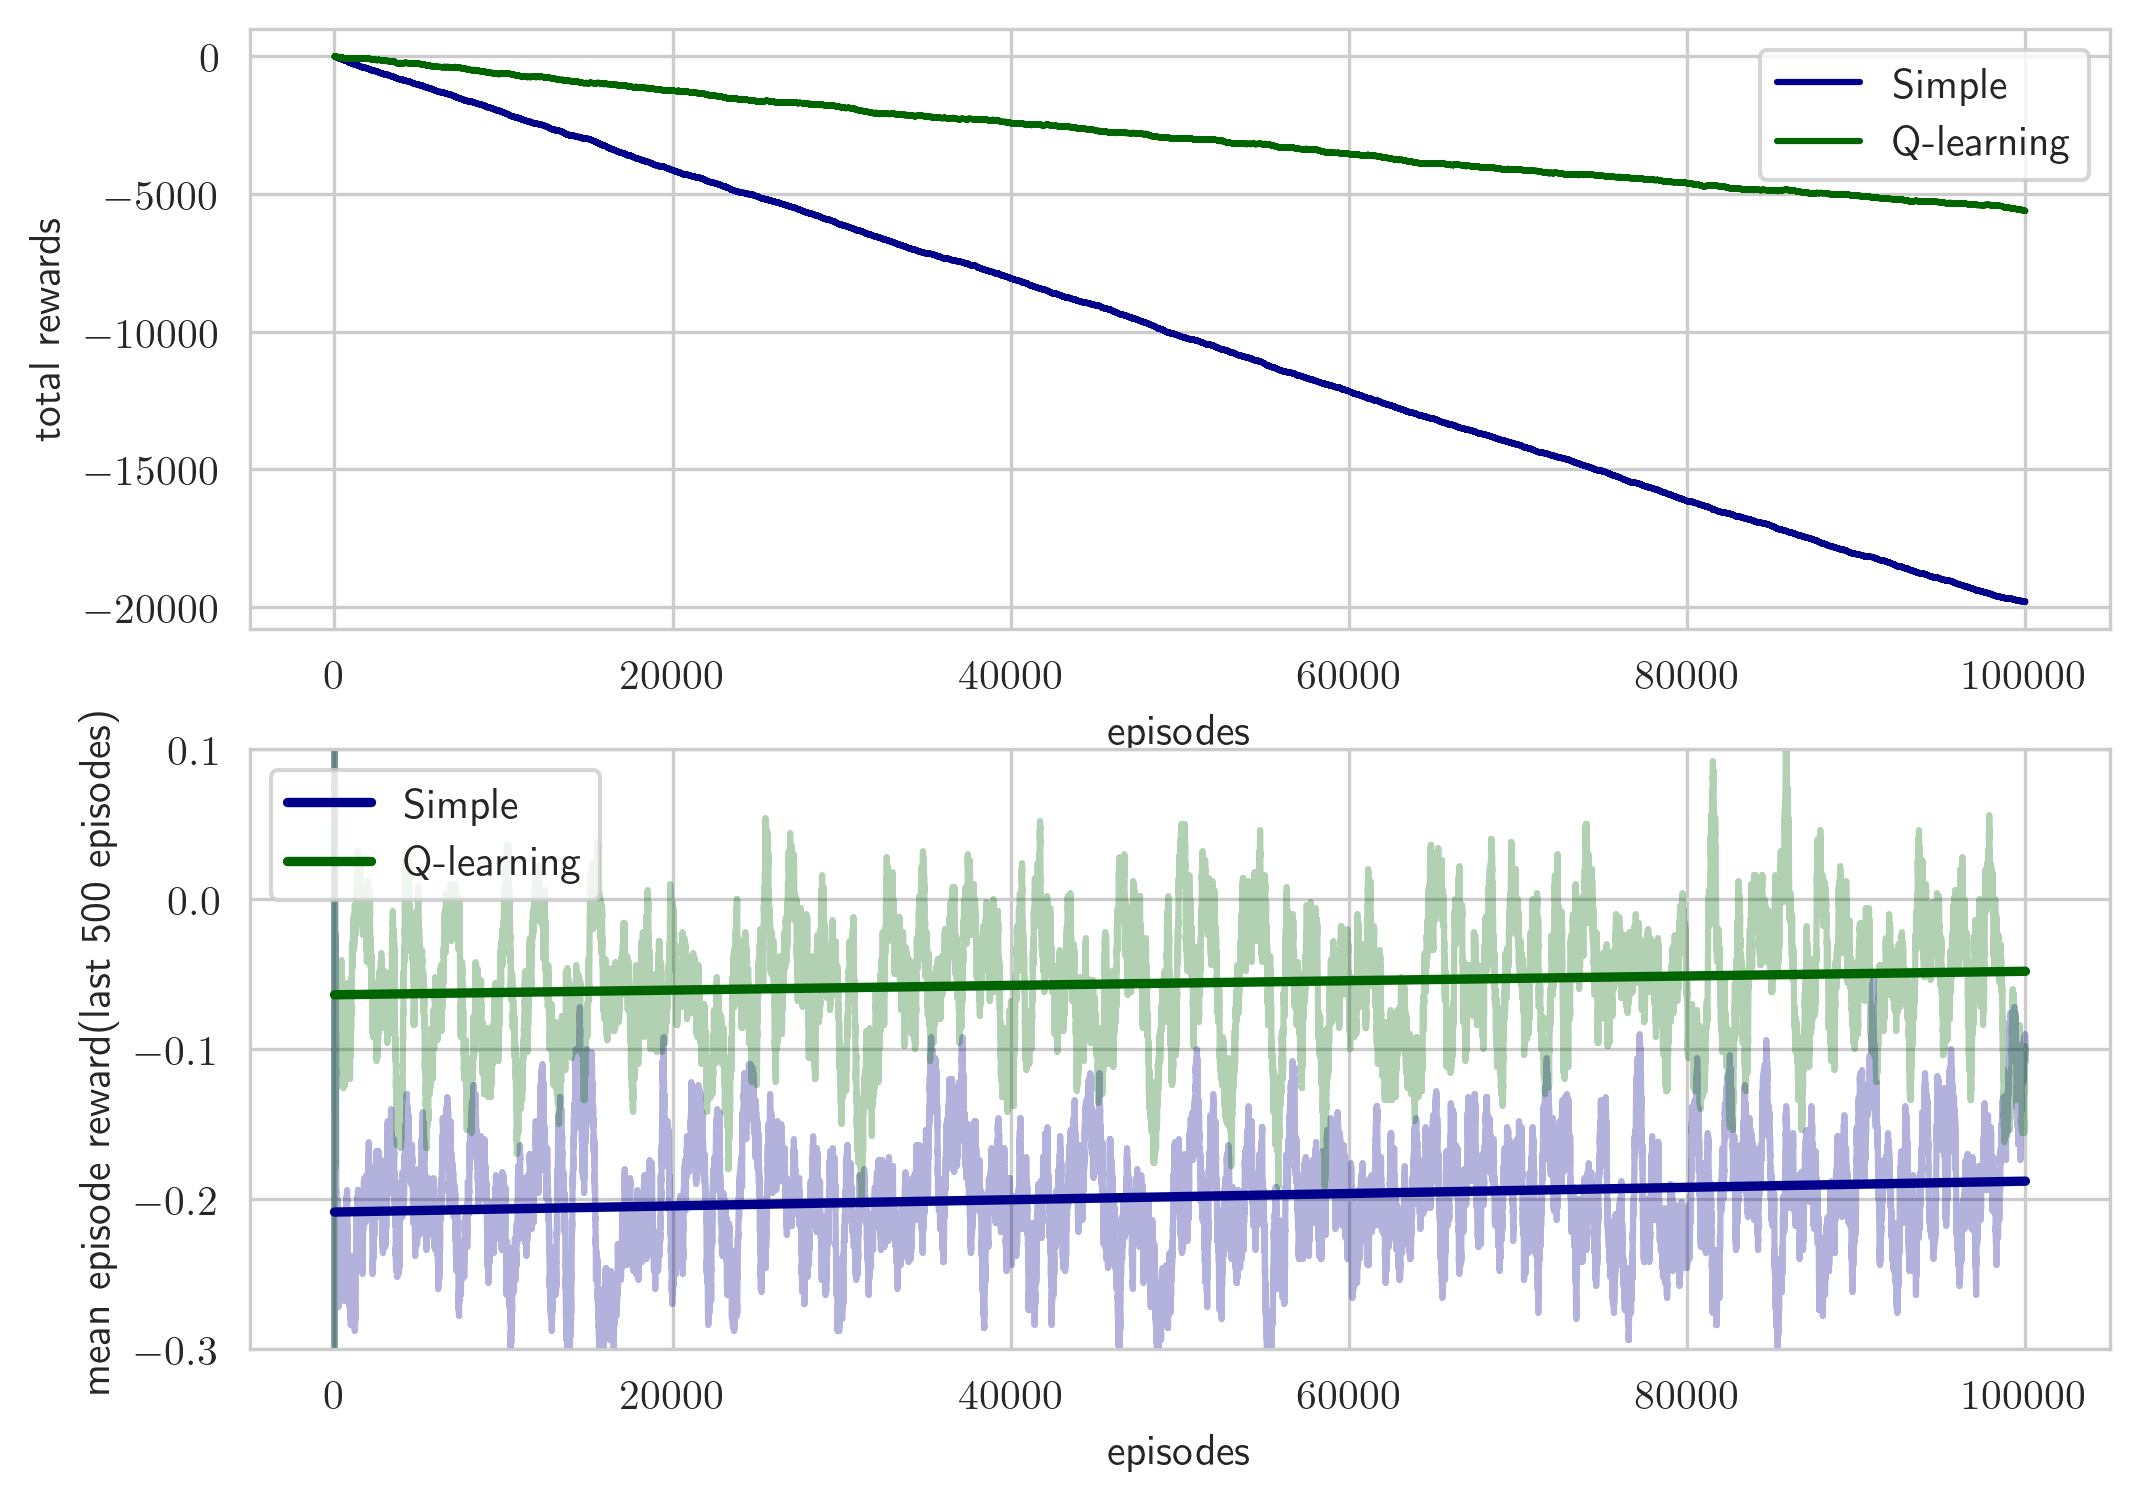

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

axes[0].plot(np.cumsum(total_reward_simple), color='DarkBlue', label='Simple')
axes[0].plot(np.cumsum(total_reward_q_opt), color='DarkGreen', label='Q-learning')
axes[0].set_xlabel('episodes')
axes[0].set_ylabel('total rewards')
axes[0].legend()

axes[1].plot(mean_reward_simple, color='DarkBlue', alpha=0.3)
axes[1].plot(mean_reward_q_opt, color='DarkGreen', alpha=0.3)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_simple,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkBlue',
    label='Simple'
)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_q_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkGreen',
    label='Q-learning'
)
axes[1].set_xlabel('episodes')
axes[1].set_ylabel(f'mean episode reward(last {K} episodes)')
axes[1].set_ylim([-0.3,0.1])
axes[1].legend()

fig.subplots_adjust(bottom=0.000)
plt.show()

#### Вывод: после оптимизации мы теряем в среднем 0.056 за эпизод, что заметно лучше результатов простой стратегии (Simple:-0.198).

### Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. <br>
Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки.<br> 
Итак, у игрока появляется дополнительное действие:
*	**double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4.	Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
5.	Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### 4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

In [20]:
# Реализация нового варианта в blackjack_double.py
from blackjack_double import BlackjackDoubleEnv

env = get_env(env_type='double')
env

#### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [26]:
A = [0, 1, 2]  # Пространство возможных действий, 2 - это действие double
S = get_states(get_env, env_type='double', actions=3, episodes=10000)  # Пространство исследованных возможных состояний
print(f'|S|={len(S)}')

# Словари для обращения к матрице Q
action_to_id = {a: i for i, a in enumerate(A)}
id_to_action = {i: a for i, a in enumerate(A)}
state_to_id = {s: i for i, s in enumerate(S)}
id_to_state = {i: s for i, s in enumerate(S)}

100%|██████████| 10000/10000 [00:02<00:00, 3928.11it/s]

|S|=380


In [27]:
def eps_greedy_Q_learning_double_strategy(alpha=0.05, epsilon=0.1, gamma=0.9, episodes=1000, debug=False):
    Q = np.zeros((len(S), len(A)))  # Инициализируем матрицу Q нулями
    total_rewards = []
    mean_rewards = []
    for i in tqdm(range(episodes)):
        if debug: print('\nSTART_episode')
        env = get_env(env_type='double')  # инициализируем окружение - DOUBLE
        observation = env.reset()  # первая раздача
        total_score = observation[0][0]  # стартовое количество очков
        state_id = state_to_id[observation[0]]
        done = False
        while not done:
            if debug: print(f'total_score={total_score}')
            # argmax с вероятностью 1-eps и случайное действие с вероятностью eps
            if np.random.rand() > epsilon:
                action_id = np.argmax(Q[state_id])
            else:
                action_id = np.random.choice(list(action_to_id.keys()))
            if debug: print(f'    action: {action_id}')
            observation, reward, done, info, _ = env.step(id_to_action[action_id])
            total_score, _, _ = observation
            state_id_new = state_to_id[observation]
            Q[state_id, action_id] = (1 - alpha) * Q[state_id, action_id] + alpha * (reward + gamma * np.max(Q[state_id_new]))
            state_id = state_id_new
        total_rewards.append(reward)
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f'episode_reward={reward}')
        if debug: print('END_episode\n')
        env.close()
    return total_rewards, mean_rewards, Q

In [28]:
# Check game
check = eps_greedy_Q_learning_double_strategy(epsilon=0.5, episodes=3, debug=True)

100%|██████████| 3/3 [00:00<00:00, 447.82it/s]


START_episode
total_score=17
    action: 2
episode_reward=0.0
END_episode


START_episode
total_score=13
    action: 0
episode_reward=-1.0
END_episode


START_episode
total_score=21
    action: 0
episode_reward=1.5
END_episode



Сразу подберем $\epsilon$, $\alpha$ и $\gamma$.

In [29]:
def optimize_reward_double(trial):
    alpha = trial.suggest_float('alpha', 0, 1)
    epsilon = trial.suggest_float('epsilon', 0, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    return np.mean(eps_greedy_Q_learning_double_strategy(alpha=alpha, epsilon=epsilon, gamma=gamma, episodes=5000)[0])

In [30]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_reward_double, n_trials=200, show_progress_bar=False)
clear_output(wait=False)

Так как матрица Q для double стратегии больше, будем вычислять ее по 5N эпизодам.

In [31]:
alpha = study.best_params['alpha']
epsilon = study.best_params['epsilon']
gamma = study.best_params['gamma']

print(f'BEST params: alpha={alpha}, epsilon={epsilon}, gamma={gamma}')
total_reward_q_double_opt, mean_reward_q_double_opt, Q_double_opt = eps_greedy_Q_learning_double_strategy(alpha=alpha, epsilon=epsilon, gamma=gamma, episodes=5*N)
print(f'Количество эпизодов: {5*N}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q_double_opt)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q_double_opt[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q_double_opt[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q_double_opt)}')

BEST params: alpha=0.06697992840600983, epsilon=0.01845828845910019, gamma=0.07983080877481989


100%|██████████| 500000/500000 [03:06<00:00, 2674.74it/s]


Количество эпизодов: 500000
Средний выигрыш за эпизод: -0.05333
Средний выигрыш за эпизод за первые 500 эпизодов: -0.299
Средний выигрыш за эпизод за последние 500 эпизодов: -0.055
Общий выигрыш по всем эпизодам: -26665.0


Графики - результат, полученный **во время вычисления матрицы Q**: сверху - суммарный доход по всем эпизодам, снизу - доход за эпизод, усредненный по предыдущим 500 эпизодам.

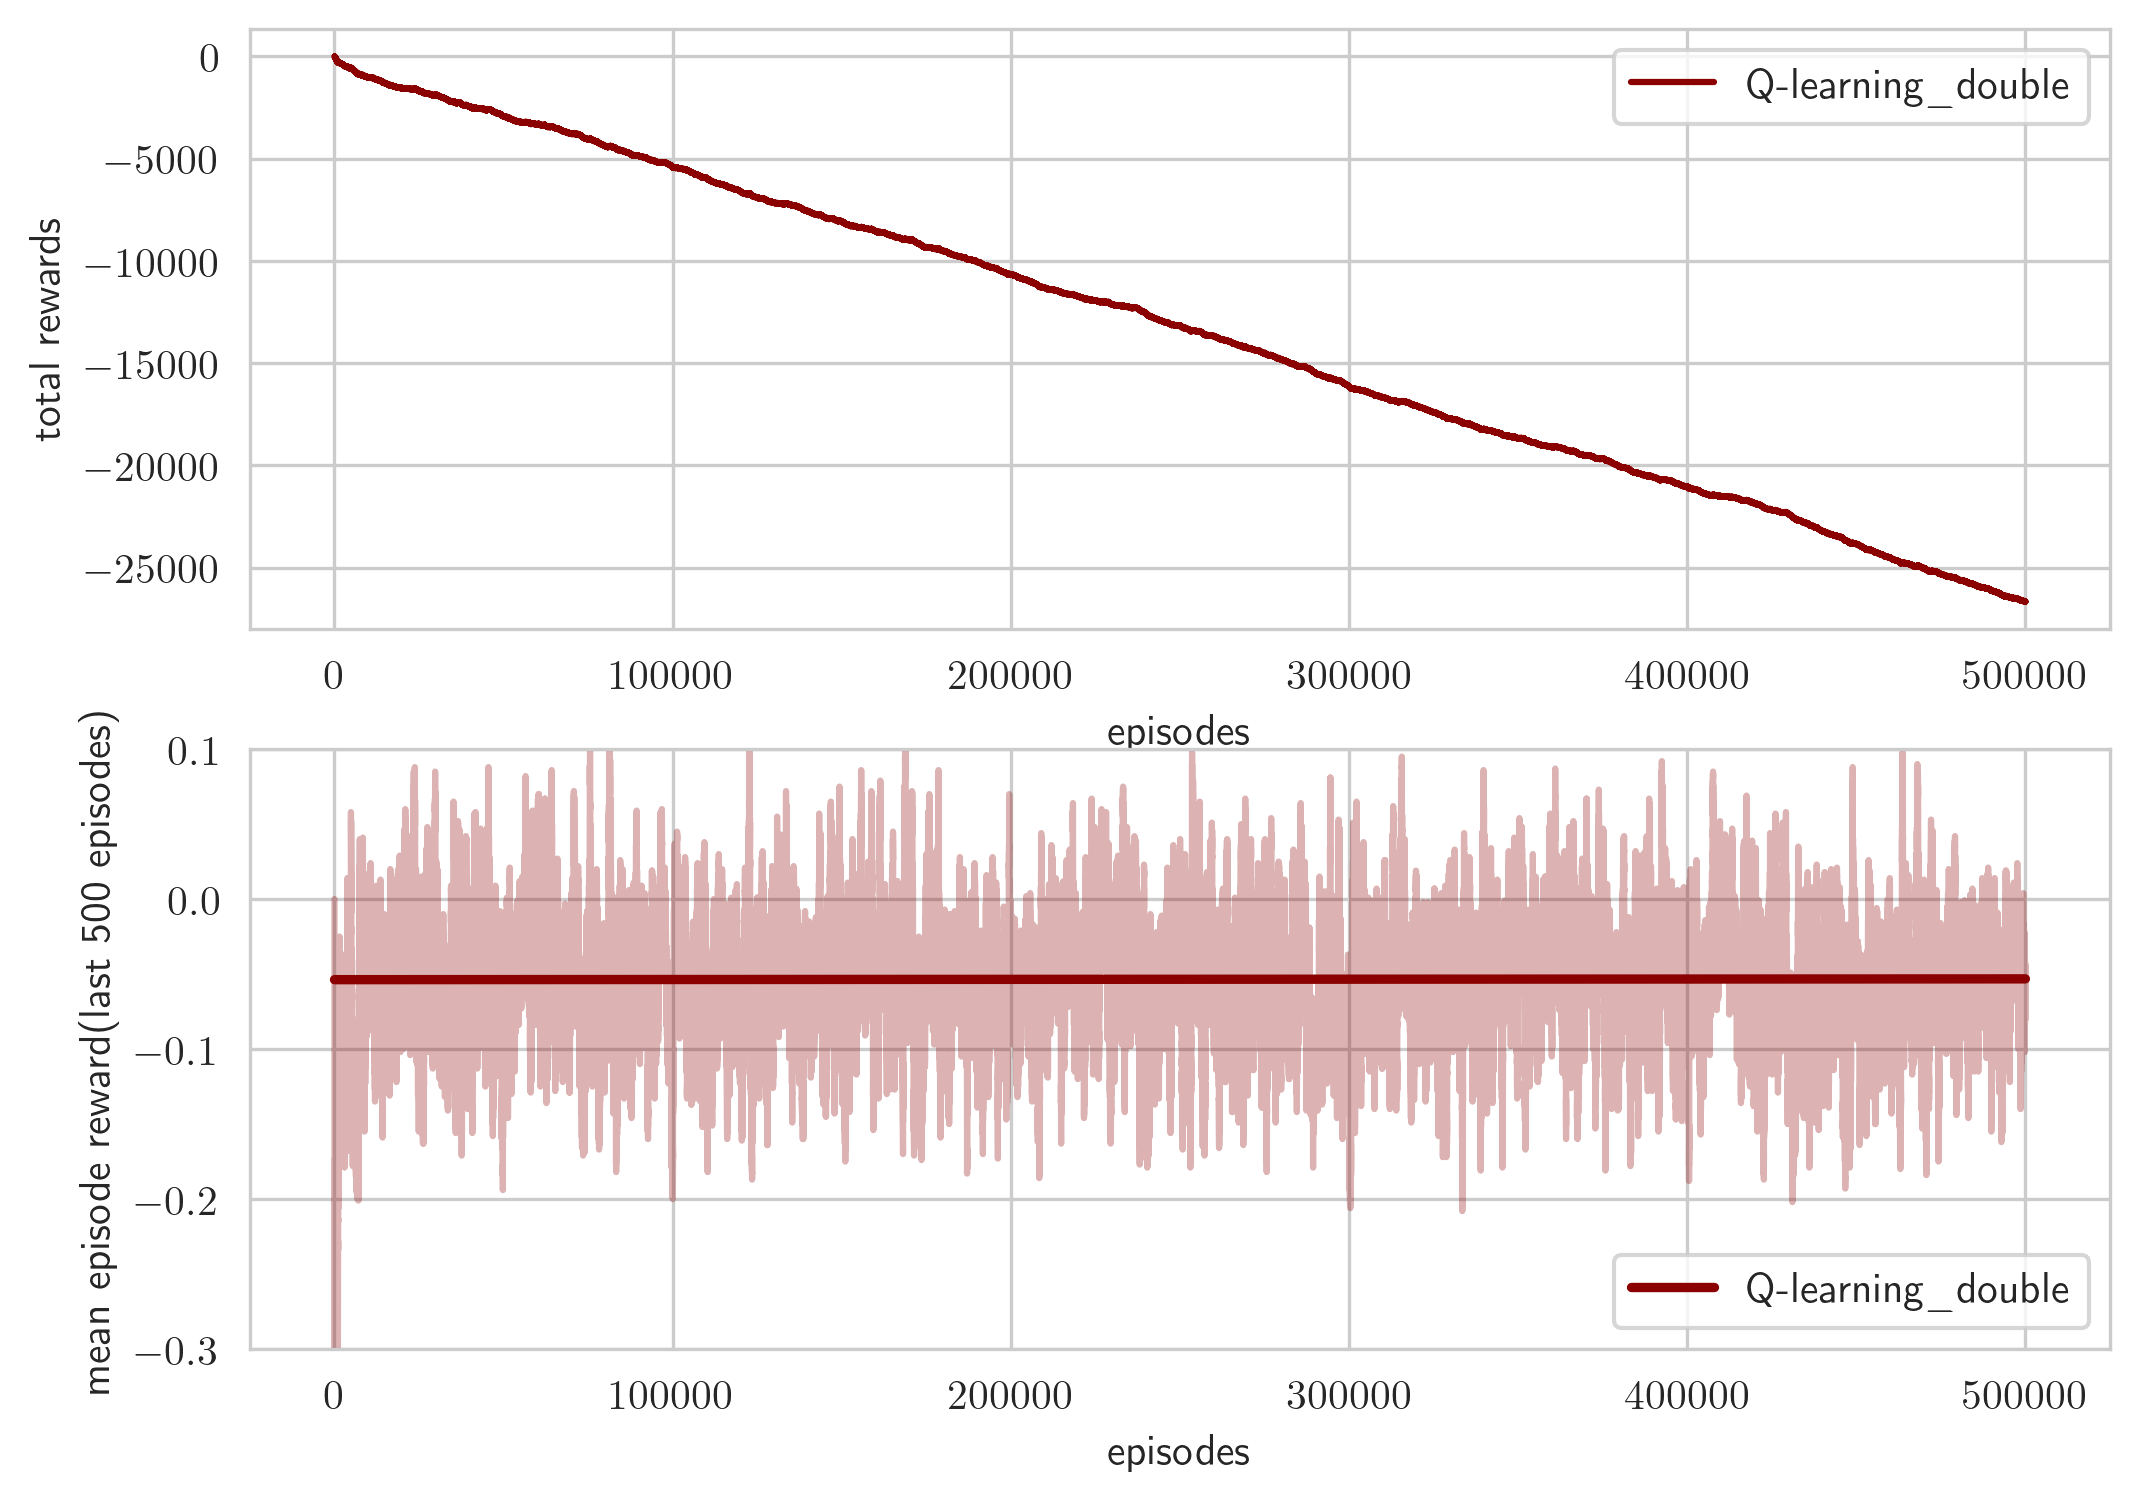

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

axes[0].plot(np.cumsum(total_reward_q_double_opt), color='DarkRed', label='Q-learning_double')
axes[0].set_xlabel('episodes')
axes[0].set_ylabel('total rewards')
axes[0].legend()

axes[1].plot(mean_reward_q_double_opt, color='DarkRed', alpha=0.3)

sns.regplot(
    x=list(range(5*N)),
    y=mean_reward_q_double_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkRed',
    label='Q-learning_double'
)
axes[1].set_xlabel('episodes')
axes[1].set_ylabel(f'mean episode reward(last {K} episodes)')
axes[1].set_ylim([-0.3,0.1])
axes[1].legend()

fig.subplots_adjust(bottom=0.000)
plt.show()

Здесь тренд на увеличение среднего дохода за эпизод не прослеживается.

Теперь проиграем 100000 эпизодов, используя полученную матрицу Q_double_opt.

In [33]:
total_reward_q_double_opt, mean_reward_q_double_opt = play_blackjack_using_Q(Q_double_opt, episodes=M, env_type='double')
print(f'Количество эпизодов: {M}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q_double_opt)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q_double_opt[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q_double_opt[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q_double_opt)}')

100%|██████████| 100000/100000 [00:34<00:00, 2885.99it/s]


Количество эпизодов: 100000
Средний выигрыш за эпизод: -0.03787
Средний выигрыш за эпизод за первые 500 эпизодов: -0.03
Средний выигрыш за эпизод за последние 500 эпизодов: -0.046
Общий выигрыш по всем эпизодам: -3787.0


Графики: сверху - суммарный доход по всем эпизодам, снизу - доход за эпизод, усредненный по предыдущим 500 эпизодам.<br>
Результаты предыдущих стратегий для сравнения.

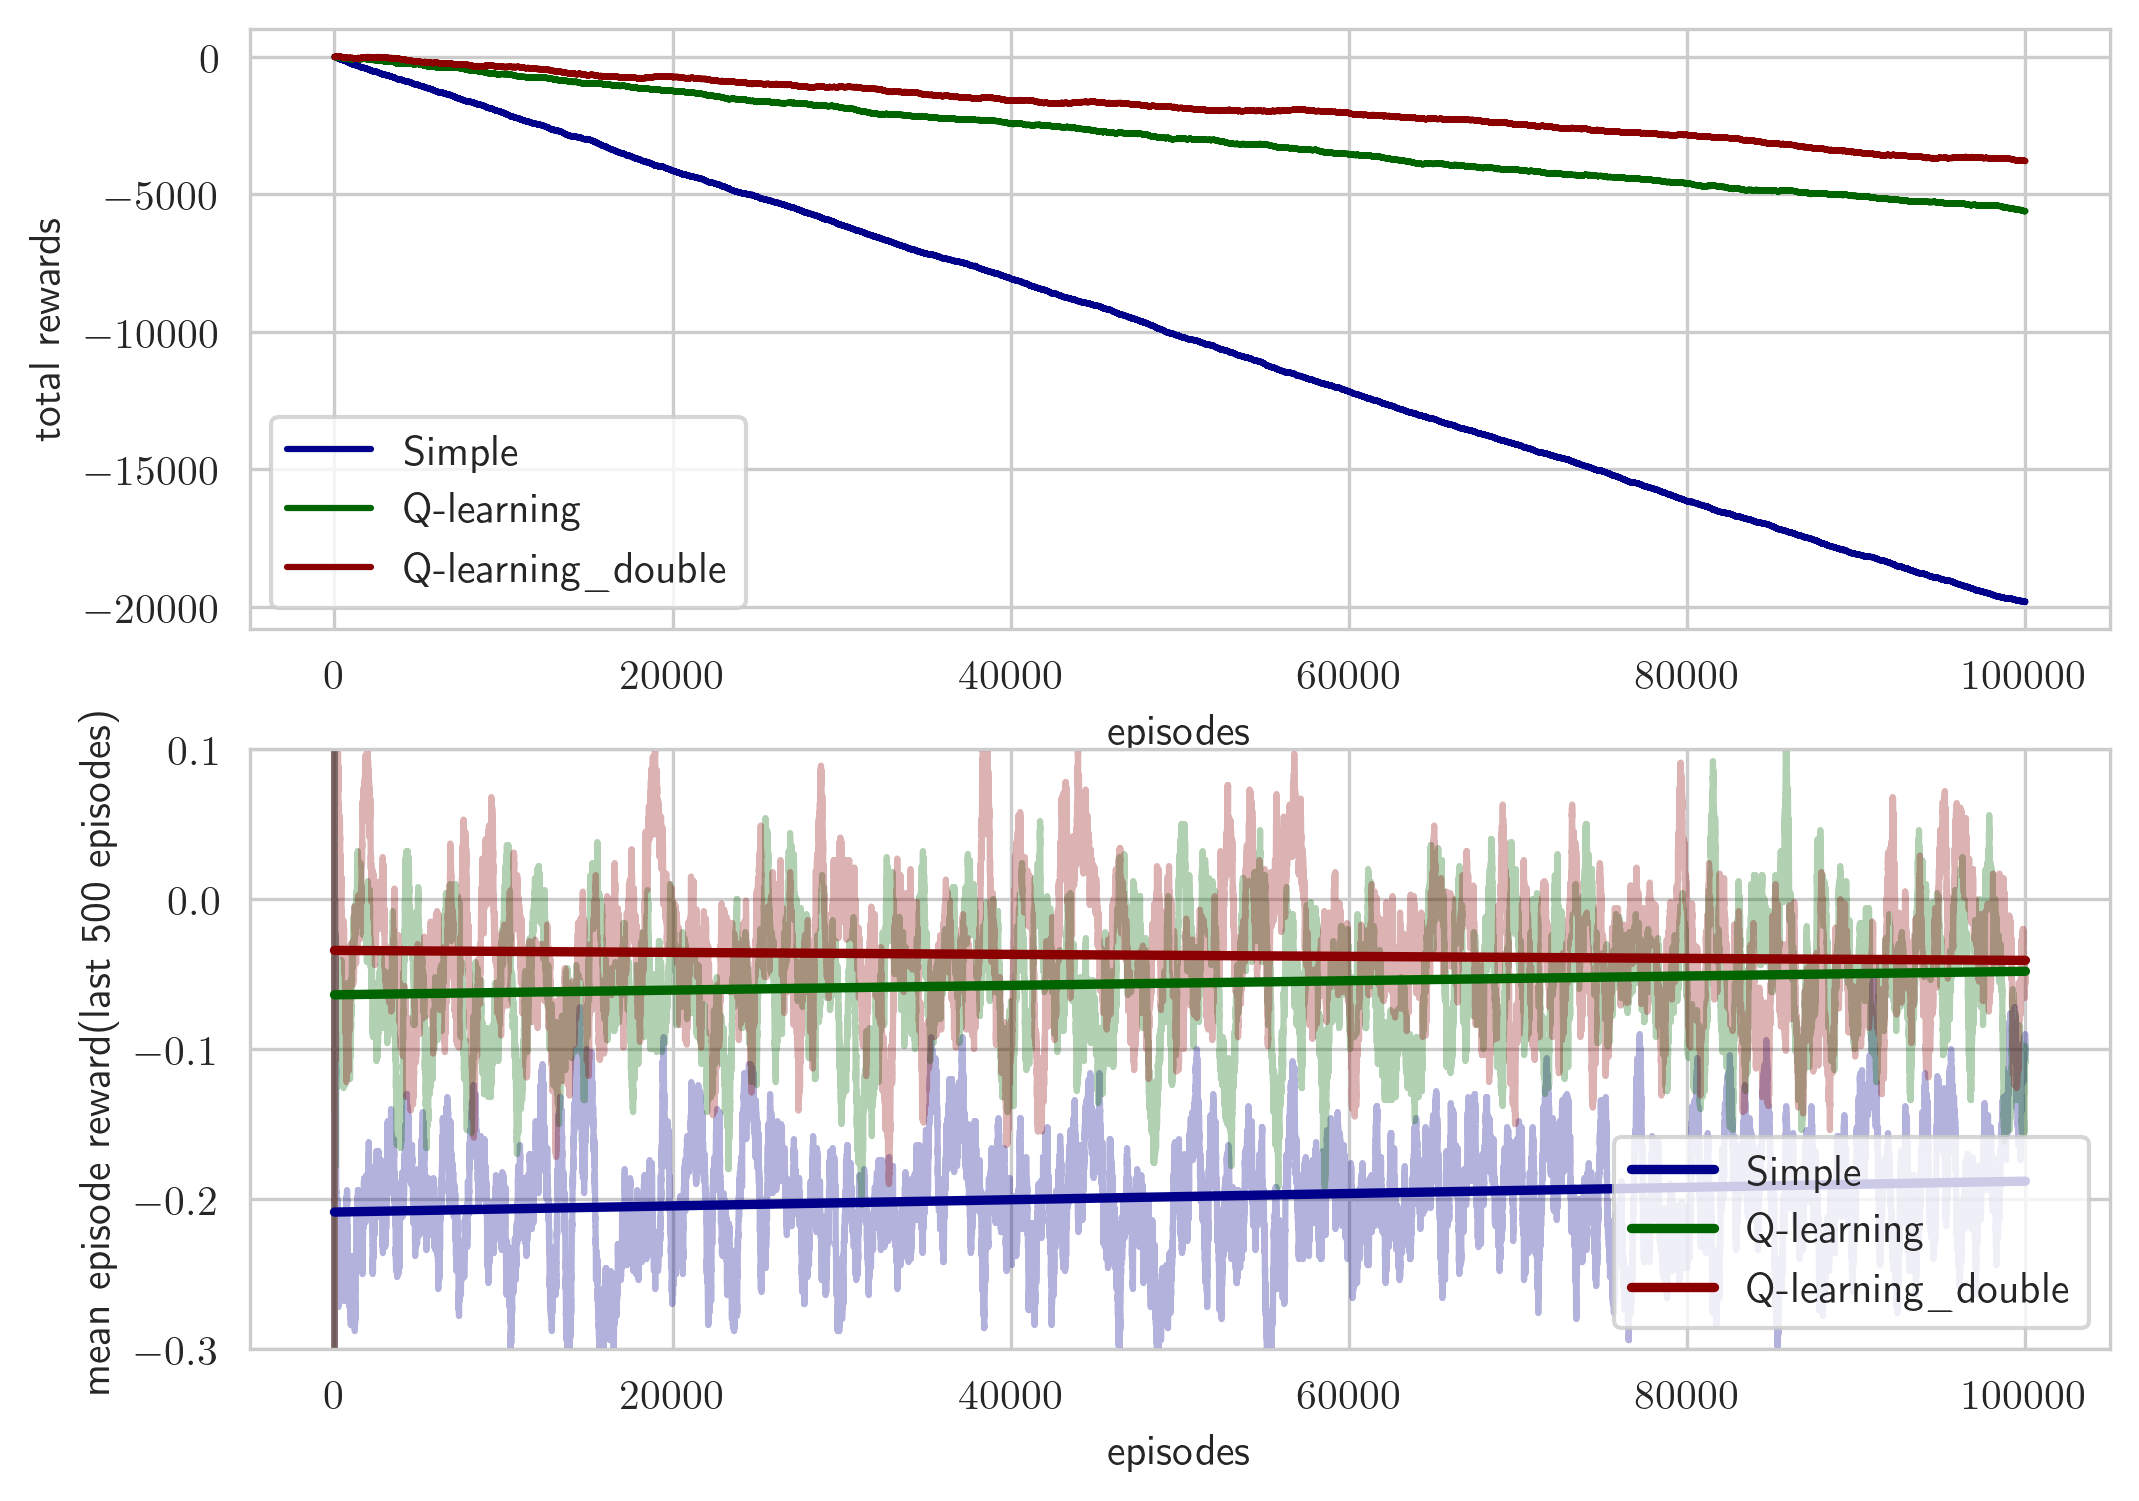

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

axes[0].plot(np.cumsum(total_reward_simple), color='DarkBlue', label='Simple')
axes[0].plot(np.cumsum(total_reward_q_opt), color='DarkGreen', label='Q-learning')
axes[0].plot(np.cumsum(total_reward_q_double_opt), color='DarkRed', label='Q-learning_double')
axes[0].set_xlabel('episodes')
axes[0].set_ylabel('total rewards')
axes[0].legend()

axes[1].plot(mean_reward_simple, color='DarkBlue', alpha=0.3)
axes[1].plot(mean_reward_q_opt, color='DarkGreen', alpha=0.3)
axes[1].plot(mean_reward_q_double_opt, color='DarkRed', alpha=0.3)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_simple,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkBlue',
    label='Simple'
)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_q_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkGreen',
    label='Q-learning'
)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_q_double_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkRed',
    label='Q-learning_double'
)
axes[1].set_xlabel('episodes')
axes[1].set_ylabel(f'mean episode reward(last {K} episodes)')
axes[1].set_ylim([-0.3,0.1])
axes[1].legend()

fig.subplots_adjust(bottom=0.000)
plt.show()

#### Вывод: стратегия с удвоением показала лучший результат по сравнению с двумя предыдущими стратегиями. С ней мы теряем примерно 0.038 за эпизод (Q-learning:-0.056, Simple:-0.198).

### Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. <br>
Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.<br>
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит.<br> 
В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6.	Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
7.	Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### 6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Используем систему подсчёта «Плюс-минус», как в фильме: <a href='https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA'>Wiki</a>

In [35]:
# Реализация нового варианта в blackjack_count.py
from blackjack_count import BlackjackDoubleCountEnv

env = get_env(env_type='count')
env

#### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [36]:
# Проигрываем большое количество эпизодов и собираем информацию о возможных состояниях
def get_states_count(get_env, env_type, actions=3, episodes=1000):
    states = []
    for i in tqdm(range(episodes)):
        env = get_env(env_type)  # инициализируем окружение
        observation = env.reset()  # первая раздача
        states.append(observation[0][:-1])
        done = False
        while not done:
            action = np.random.randint(0, actions)
            observation, reward, done, info, _ = env.step(action)
            states.append(observation[:-1])
        env.close()
    return list(set(states))  # Сразу уберем дублированные состояния

In [37]:
# Здесь мы немного схитрим и искусственно дополним пространство состояний возможными суммами очков
# Получилось вычислительно сложно собрать все кейсы
import itertools

A = [0, 1, 2]  # Пространство возможных действий, 2 - это действие double
S = get_states_count(get_env, env_type='count', actions=3, episodes=10000)  # Пространство исследованных возможных состояний
print(f'|S|={len(S)}')
S = [(*S, cnt) for S, cnt in itertools.product(S, np.arange(-20, 21, 1))]  # Дополненное пространство состояний
print(f'|S|={len(S)}')

# Словари для обращения к матрице Q
action_to_id = {a: i for i, a in enumerate(A)}
id_to_action = {i: a for i, a in enumerate(A)}
state_to_id = {s: i for i, s in enumerate(S)}
id_to_state = {i: s for i, s in enumerate(S)}

100%|██████████| 10000/10000 [00:02<00:00, 3665.47it/s]

|S|=380
|S|=15580


In [38]:
def eps_greedy_Q_learning_double_count_strategy(alpha=0.05, epsilon=0.1, gamma=0.9, episodes=1000, debug=False):
    Q = np.zeros((len(S), len(A)))  # Инициализируем матрицу Q нулями
    total_rewards = []
    mean_rewards = []
    for i in tqdm(range(episodes)):
        if debug: print('\nSTART_episode')
        env = get_env(env_type='count')  # инициализируем окружение - COUNT
        observation = env.reset()  # первая раздача
        total_score = observation[0][0]  # стартовое количество очков
        state_id = state_to_id[observation[0]]
        done = False
        while not done:
            if debug: print(f'total_score={total_score}')
            # argmax с вероятностью 1-eps и случайное действие с вероятностью eps
            if np.random.rand() > epsilon:
                action_id = np.argmax(Q[state_id])
            else:
                action_id = np.random.choice(list(action_to_id.keys()))
            if debug: print(f'    action: {action_id}')
            observation, reward, done, info, _ = env.step(id_to_action[action_id])
            total_score, _, _, _ = observation
            state_id_new = state_to_id[observation]
            Q[state_id, action_id] = (1 - alpha) * Q[state_id, action_id] + alpha * (reward + gamma * np.max(Q[state_id_new]))
            state_id = state_id_new
        total_rewards.append(reward)
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f'episode_reward={reward}')
        if debug: print('END_episode\n')
        env.close()
    return total_rewards, mean_rewards, Q

In [39]:
# Check game
check = eps_greedy_Q_learning_double_count_strategy(epsilon=0.5, episodes=3, debug=True)

100%|██████████| 3/3 [00:00<00:00, 366.89it/s]


START_episode
total_score=17
    action: 0
episode_reward=-1.0
END_episode


START_episode
total_score=19
    action: 0
episode_reward=1.0
END_episode


START_episode
total_score=17
    action: 1
total_score=20
    action: 1
total_score=21
    action: 0
episode_reward=1.0
END_episode



Сразу подберем $\epsilon$, $\alpha$ и $\gamma$.

In [40]:
def optimize_reward_double_count(trial):
    alpha = trial.suggest_float('alpha', 0, 1)
    epsilon = trial.suggest_float('epsilon', 0, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    return np.mean(eps_greedy_Q_learning_double_count_strategy(alpha=alpha, epsilon=epsilon, gamma=gamma, episodes=5000)[0])

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_reward_double_count, n_trials=200, show_progress_bar=False)
clear_output(wait=False)

В стратегии с подсчетом пространство состояний еще больше, поэтому будем вычислять матрицу Q по 10N эпизодам.

In [42]:
alpha = study.best_params['alpha']
epsilon = study.best_params['epsilon']
gamma = study.best_params['gamma']

print(f'BEST params: alpha={alpha}, epsilon={epsilon}, gamma={gamma}')
total_reward_q_double_count_opt, mean_reward_q_double_count_opt, Q_double_count_opt = eps_greedy_Q_learning_double_count_strategy(alpha=alpha, epsilon=epsilon, gamma=gamma, episodes=10*N)
print(f'Количество эпизодов: {10*N}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q_double_count_opt)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q_double_count_opt[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q_double_count_opt[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q_double_count_opt)}')

BEST params: alpha=0.06907083889114968, epsilon=0.038263238336450844, gamma=0.06785715227755555


100%|██████████| 1000000/1000000 [06:20<00:00, 2627.79it/s]


Количество эпизодов: 1000000
Средний выигрыш за эпизод: -0.06392
Средний выигрыш за эпизод за первые 500 эпизодов: -0.173
Средний выигрыш за эпизод за последние 500 эпизодов: -0.07
Общий выигрыш по всем эпизодам: -63920.0


Графики - результат, полученный **во время вычисления матрицы Q**: сверху - суммарный доход по всем эпизодам, снизу - доход за эпизод, усредненный по предыдущим 500 эпизодам.

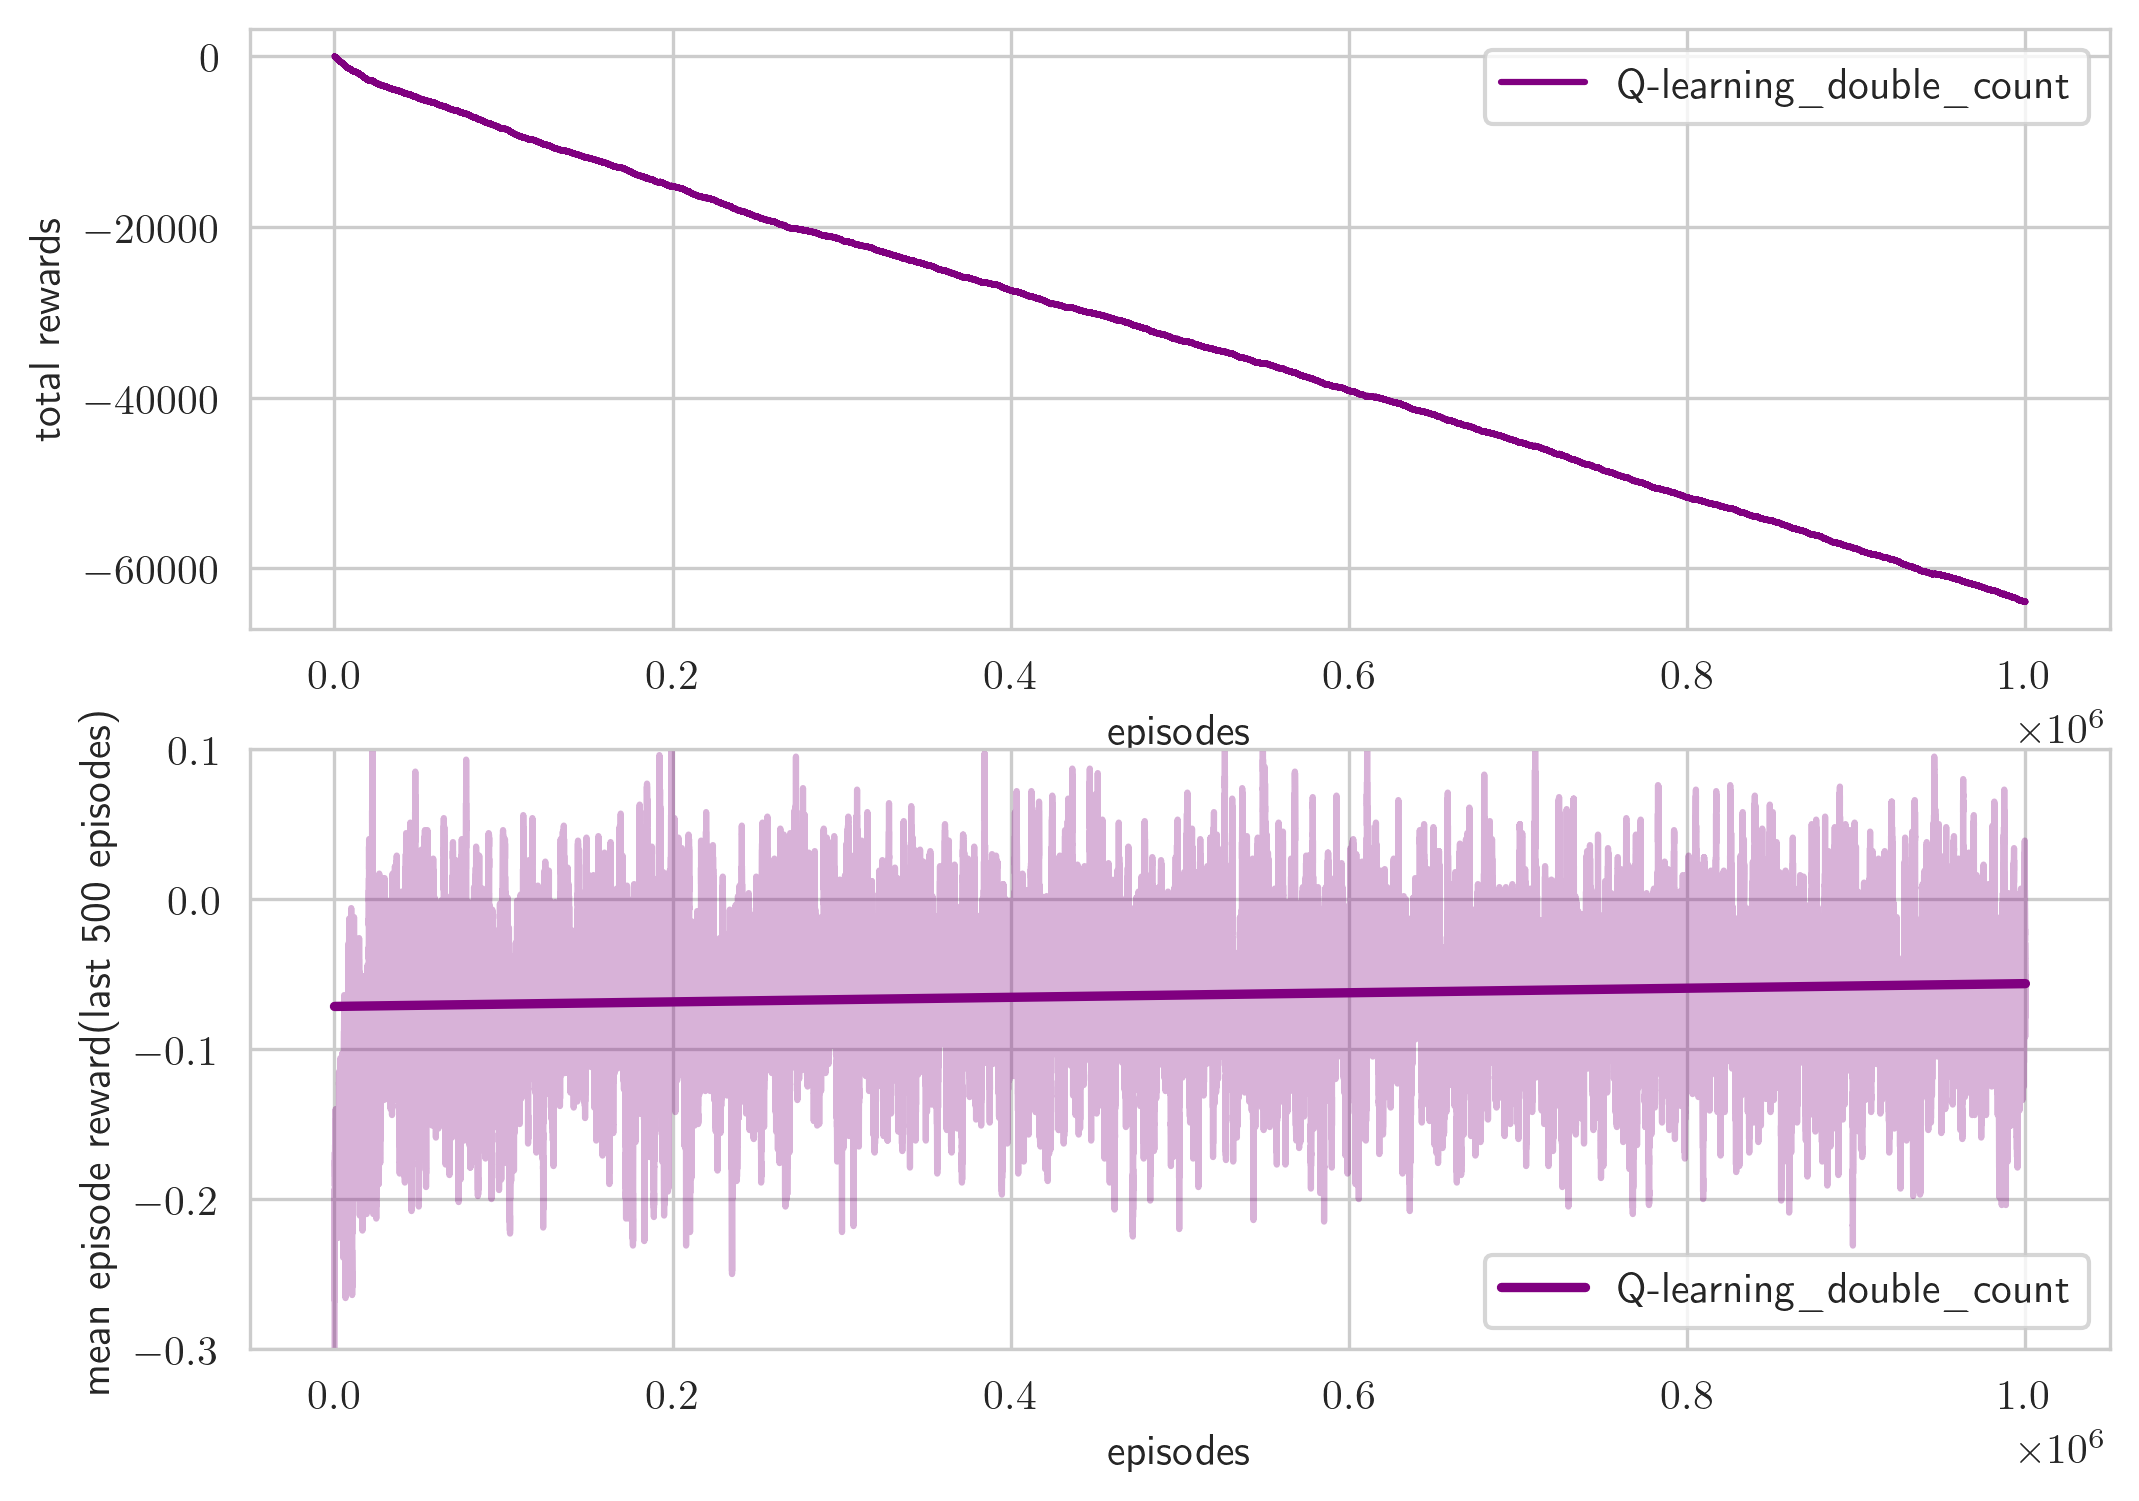

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

axes[0].plot(np.cumsum(total_reward_q_double_count_opt), color='Purple', label='Q-learning_double_count')
axes[0].set_xlabel('episodes')
axes[0].set_ylabel('total rewards')
axes[0].legend()

axes[1].plot(mean_reward_q_double_count_opt, color='Purple', alpha=0.3)

sns.regplot(
    x=list(range(10*N)),
    y=mean_reward_q_double_count_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='Purple',
    label='Q-learning_double_count'
)
axes[1].set_xlabel('episodes')
axes[1].set_ylabel(f'mean episode reward(last {K} episodes)')
axes[1].set_ylim([-0.3,0.1])
axes[1].legend()

fig.subplots_adjust(bottom=0.000)
plt.show()

Здесь тренд на увеличение среднего дохода от эпизода еле-еле, но все-таки заметен.

Теперь проиграем 100000 эпизодов, используя полученную матрицу Q_double_count_opt.

In [44]:
total_reward_q_double_count_opt, mean_reward_q_double_count_opt = play_blackjack_using_Q(Q_double_count_opt, episodes=M, env_type='count')
print(f'Количество эпизодов: {M}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q_double_count_opt)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q_double_count_opt[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q_double_count_opt[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q_double_count_opt)}')

100%|██████████| 100000/100000 [00:35<00:00, 2821.71it/s]


Количество эпизодов: 100000
Средний выигрыш за эпизод: -0.037225
Средний выигрыш за эпизод за первые 500 эпизодов: -0.04
Средний выигрыш за эпизод за последние 500 эпизодов: -0.041
Общий выигрыш по всем эпизодам: -3722.5


Графики: сверху - суммарный доход по всем эпизодам, снизу - доход за эпизод, усредненный по предыдущим 500 эпизодам.<br>
Результаты предыдущих стратегий для сравнения.

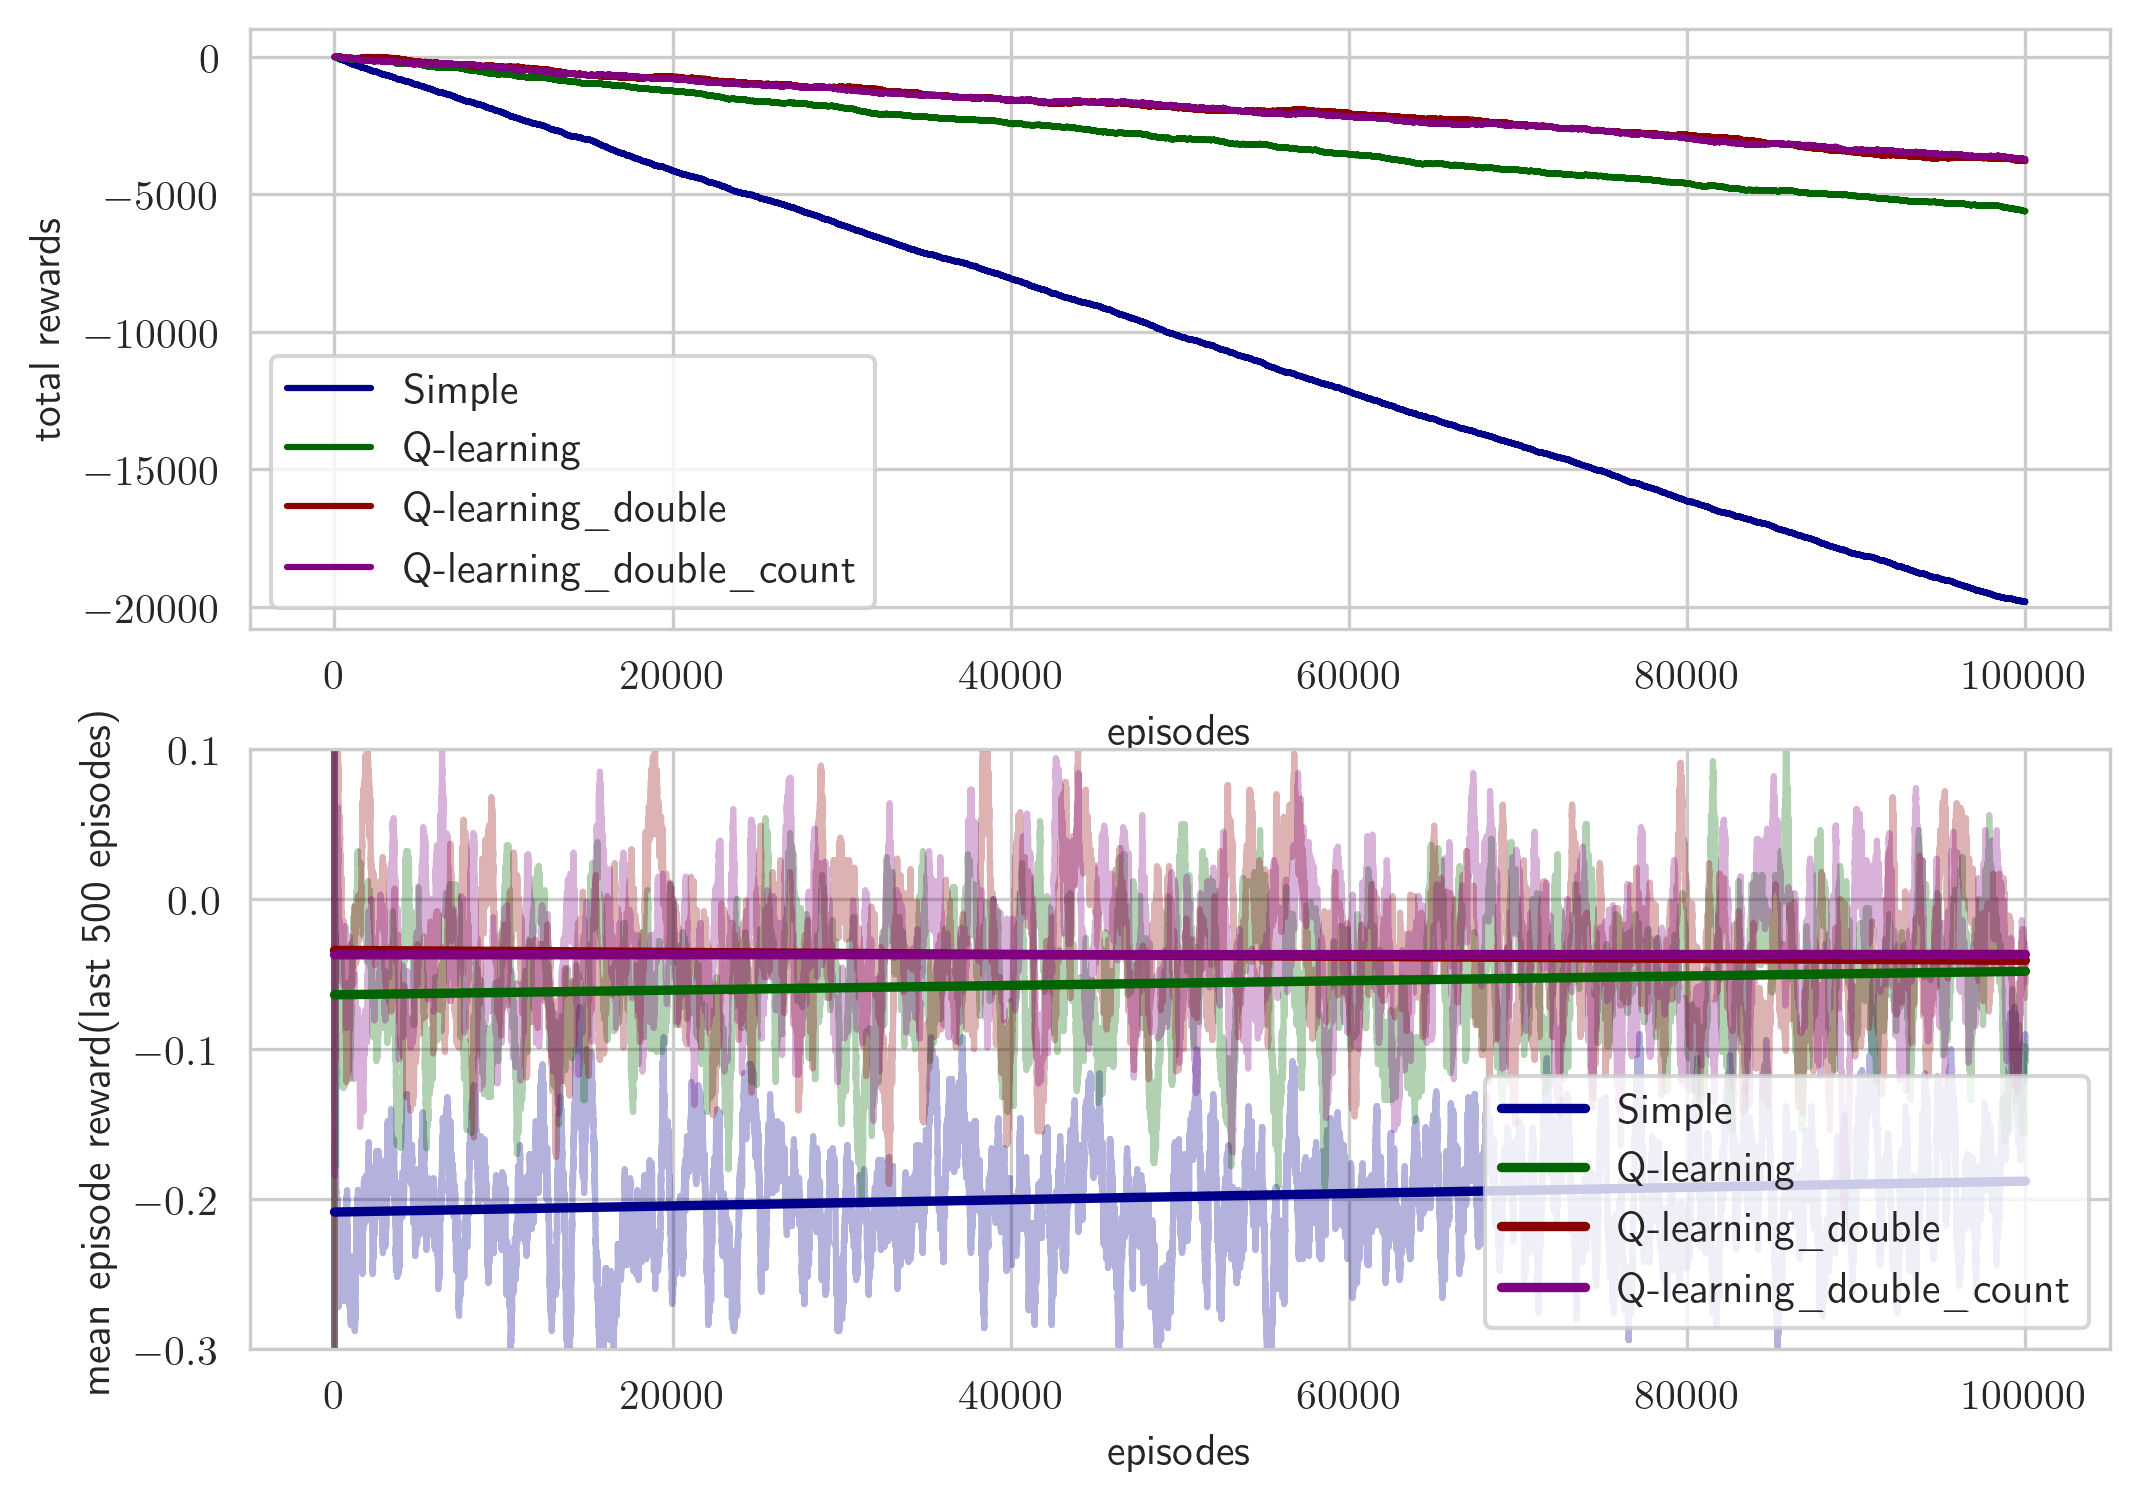

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

axes[0].plot(np.cumsum(total_reward_simple), color='DarkBlue', label='Simple')
axes[0].plot(np.cumsum(total_reward_q_opt), color='DarkGreen', label='Q-learning')
axes[0].plot(np.cumsum(total_reward_q_double_opt), color='DarkRed', label='Q-learning_double')
axes[0].plot(np.cumsum(total_reward_q_double_count_opt), color='Purple', label='Q-learning_double_count')
axes[0].set_xlabel('episodes')
axes[0].set_ylabel('total rewards')
axes[0].legend()

axes[1].plot(mean_reward_simple, color='DarkBlue', alpha=0.3)
axes[1].plot(mean_reward_q_opt, color='DarkGreen', alpha=0.3)
axes[1].plot(mean_reward_q_double_opt, color='DarkRed', alpha=0.3)
axes[1].plot(mean_reward_q_double_count_opt, color='Purple', alpha=0.3)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_simple,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkBlue',
    label='Simple'
)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_q_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkGreen',
    label='Q-learning'
)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_q_double_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='DarkRed',
    label='Q-learning_double'
)

sns.regplot(
    x=list(range(M)),
    y=mean_reward_q_double_count_opt,
    ax=axes[1],
    scatter=False,
    fit_reg=True,
    color='Purple',
    label='Q-learning_double_count'
)
axes[1].set_xlabel('episodes')
axes[1].set_ylabel(f'mean episode reward(last {K} episodes)')
axes[1].set_ylim([-0.3,0.1])
axes[1].legend()

fig.subplots_adjust(bottom=0.000)
plt.show()

#### Вывод: стратегия с подсчетом оказалась наименее разорительной. С ней мы теряем примерно 0.037 за эпизод (Q-learning_double: 0.038, Q-learning:-0.056, Simple:-0.198).<br>Вообще получилось, что стратегия с подсчетом особо не дала прироста по сравнению со стратегией с удвоением (ну хотя бы не оказалась хуже). Возможно, чтобы увидеть разницу, надо уточнять матрицу Q  на еще бОльшем количестве эпизодов.